<a href="https://colab.research.google.com/github/swapnil-1357/ML_LAB/blob/main/002211001123_SWAPNIL_MAL_ASS3_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name: Swapnil Mal

  Department: IT
  
  Section:A3
  
  Roll:002211001123
  
  Assignment 3
  
  Git hub link: **

--------------->>>> Gaussian HMM on Breast Cancer Dataset

In [ ]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 2.8 MB/s eta 0:00:00


In [ ]:
## importing all files.......
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from hmmlearn.hmm import GaussianHMM, MultinomialHMM
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")

In [ ]:
## Loading datas for breast cancer here.......
# Load dataset
data = load_breast_cancer()
X = data['data']
y = data['target']

In [ ]:
# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42, stratify=y)

In [ ]:
# Train Gaussian HMM
classifier = GaussianHMM(n_components=4, covariance_type="full", n_iter=200, random_state=42)
classifier.fit(X_train)

GaussianHMM(covariance_type='full', n_components=4, n_iter=200, random_state=42)

[[170   0]
 [285   1]]
-----------------------------------------
Performance Evaluation...
              precision    recall  f1-score   support

           0       0.37      1.00      0.54       170
           1       1.00      0.00      0.01       286

    accuracy                           0.38       456
   macro avg       0.69      0.50      0.28       456
weighted avg       0.77      0.38      0.21       456

-----------------------------------------


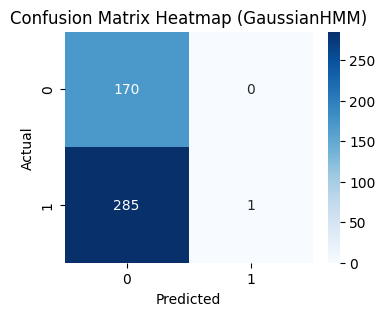

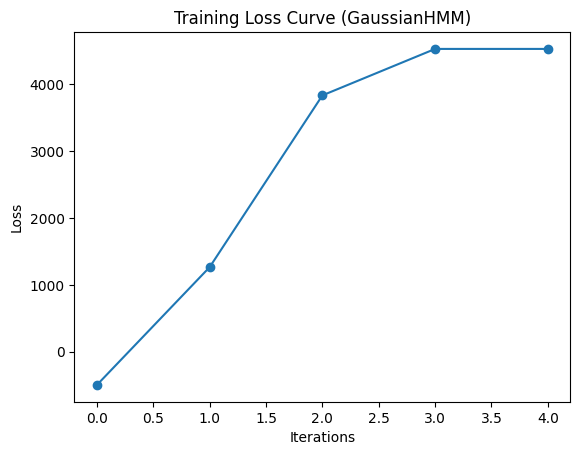

In [ ]:
y_pred=classifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("-----------------------------------------")
print("Performance Evaluation...")
print(classification_report(y_test,y_pred))
print("-----------------------------------------")

##plotting the heatmap of the cinfusion matrix
cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Heatmap (GaussianHMM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Training Loss Curve
loss_values = classifier.monitor_.history

plt.plot(loss_values, marker='o')
plt.title("Training Loss Curve (GaussianHMM)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

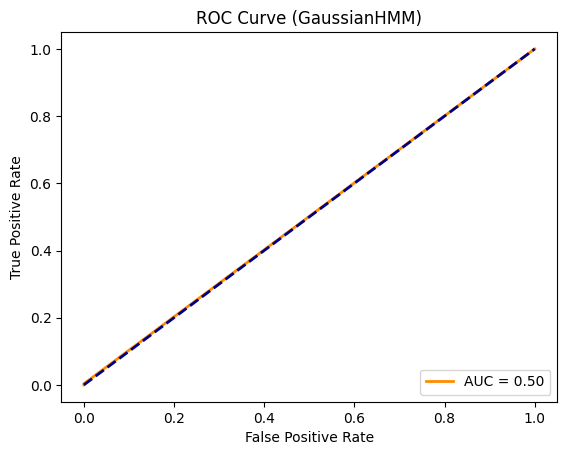

In [ ]:
# For ROC, we need probability scores
y_score = classifier.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color="darkorange", lw=2, label="AUC = {:.2f}".format(roc_auc))
plt.plot([0,1],[0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (GaussianHMM)")
plt.legend(loc="lower right")
plt.show()

-------------->>>>>> Multinomial HMM on Breast Cancer Dataset

In [ ]:
# Load dataset
data = load_breast_cancer()
X_raw = data.data
y = data.target  # 0/1 (malignant=0, benign=1)

# Standardize and discretize data for MultinomialHMM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

n_bins = 10  # tune if needed
kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
X_disc = kbd.fit_transform(X_scaled).astype(int)
n_features = X_disc.shape[1]

print("Data ready. Shape:", X_disc.shape)


Data ready. Shape: (569, 30)


In [ ]:
# ✅ Fixed helper functions for MultinomialHMM (new hmmlearn >= 0.3)

def sample_to_obs(seq_row):
    """
    Convert one sample (discrete feature vector) into a valid observation sequence
    for MultinomialHMM new API.
    Each observation = integer count vector (1 at that feature’s bin index).
    """
    obs = np.zeros((len(seq_row), n_bins), dtype=int)
    for i, val in enumerate(seq_row):
        obs[i, int(val)] = 1
    return obs

def train_class_hmms(X_disc_train, y_train, n_components=3, n_iter=100, random_state=42, verbose=False):
    models = {}
    classes = np.unique(y_train)
    for c in classes:
        Xc = X_disc_train[y_train == c]
        # concatenate all sequences
        obs_concat = np.vstack([sample_to_obs(row) for row in Xc])
        lengths = [n_features] * Xc.shape[0]
        model = MultinomialHMM(n_components=n_components, n_iter=n_iter,
                               random_state=random_state, verbose=verbose, tol=1e-4)
        model.fit(obs_concat, lengths)
        models[c] = model
    return models

def predict_hmms(models, X_disc_test):
    scores = np.zeros((X_disc_test.shape[0], len(models)))
    classes = sorted(models.keys())
    for i, row in enumerate(X_disc_test):
        obs = sample_to_obs(row)
        for j, c in enumerate(classes):
            try:
                scores[i, j] = models[c].score(obs)
            except:
                scores[i, j] = -1e9
    preds = np.array(classes)[np.argmax(scores, axis=1)]
    return preds, scores, classes

def scores_to_prob(scores, classes, positive_class=1):
    exp = np.exp(scores - np.max(scores, axis=1, keepdims=True))
    probs = exp / exp.sum(axis=1, keepdims=True)
    idx = list(classes).index(positive_class)
    return probs[:, idx]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

splits = [0.2, 0.3, 0.4]
results = []

for test_size in splits:
    X_train, X_test, y_train, y_test = train_test_split(X_disc, y, test_size=test_size,
                                                        stratify=y, random_state=42)
    models = train_class_hmms(X_train, y_train, n_components=3, n_iter=100, random_state=42)
    y_pred, scores, classes = predict_hmms(models, X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    y_prob_pos = scores_to_prob(scores, list(classes), positive_class=1)
    fpr, tpr, _ = roc_curve(y_test, y_prob_pos)
    roc_auc = auc(fpr, tpr)

    results.append({
        "test_size": test_size,
        "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
        "confusion_matrix": cm, "fpr": fpr, "tpr": tpr, "roc_auc": roc_auc,
        "models": models
    })

    print(f"\n--- test_size={test_size} ---")
    print(cm)
    print(classification_report(y_test, y_pred))


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



--- test_size=0.2 ---
[[39  3]
 [11 61]]
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        42
           1       0.95      0.85      0.90        72

    accuracy                           0.88       114
   macro avg       0.87      0.89      0.87       114
weighted avg       0.89      0.88      0.88       114



https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



--- test_size=0.3 ---
[[60  4]
 [13 94]]
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        64
           1       0.96      0.88      0.92       107

    accuracy                           0.90       171
   macro avg       0.89      0.91      0.90       171
weighted avg       0.91      0.90      0.90       171



https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



--- test_size=0.4 ---
[[ 79   6]
 [ 18 125]]
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        85
           1       0.95      0.87      0.91       143

    accuracy                           0.89       228
   macro avg       0.88      0.90      0.89       228
weighted avg       0.90      0.89      0.90       228



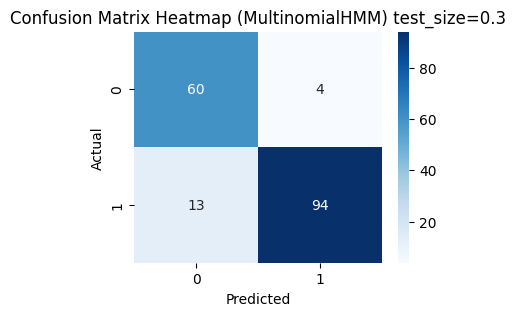

In [ ]:
best = max(results, key=lambda r: r["accuracy"])
cm = best["confusion_matrix"]

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix Heatmap (MultinomialHMM) test_size={best['test_size']}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
         1  -18866.63938196             +nan
         2  -16511.36186422   +2355.27751774
         3  -16445.83374319     +65.52812103
         4  -16401.79112693     +44.04261626
         5  -16354.92370704     +46.86741989
         6  -16300.60943459     +54.31427245
         7  -16243.35359616     +57.25583843
         8  -16191.33088881     +52.02270735
         9  -16148.82197703     +42.50891178
        10  -16115.36270578     +33.45927125
        11  -16089.10510462     +26.25760116
        12  -16068.74352373     +20.36158089
        13  -16053.15239768     +15.59112605
        14  -16041.13917578     +12.01322190
        15  -16031.71428977      +9.42488601
        16  -16024.20061734      +7.51367243
        17  -16018.14688973      +6.05372762
        18  -16013.22948124      +4.91740848
        19  -16009.20267574      +4.02680550
        20  -16005.87908771      +3.32358803
    

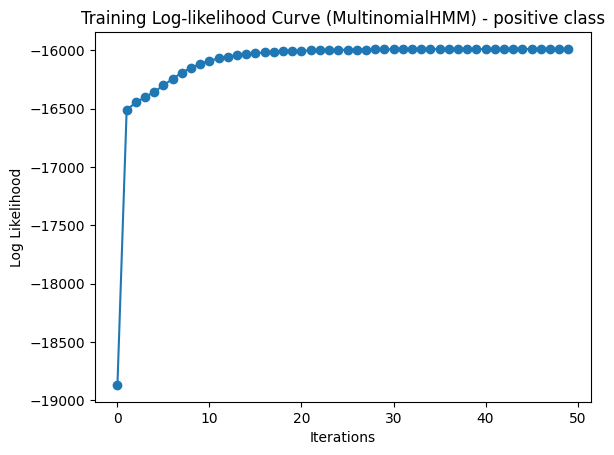

In [ ]:
from sklearn.model_selection import train_test_split

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_disc, y, test_size=best['test_size'], stratify=y, random_state=42
)
Xc = X_train_full[y_train_full == 1]
obs_concat = np.vstack([sample_to_obs(row) for row in Xc])
lengths = [n_features] * Xc.shape[0]

pos_model_v = MultinomialHMM(n_components=3, n_iter=50, verbose=True, random_state=42)
pos_model_v.n_features = n_bins
pos_model_v.fit(obs_concat, lengths)

loss_values = pos_model_v.monitor_.history

plt.plot(loss_values, marker='o')
plt.title("Training Log-likelihood Curve (MultinomialHMM) - positive class")
plt.xlabel("Iterations")
plt.ylabel("Log Likelihood")
plt.show()


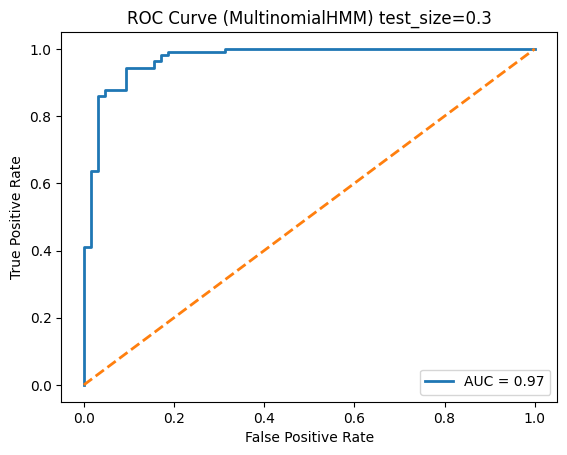

In [ ]:
plt.plot(best["fpr"], best["tpr"], lw=2, label=f"AUC = {best['roc_auc']:.2f}")
plt.plot([0,1],[0,1], lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (MultinomialHMM) test_size={best['test_size']}")
plt.legend(loc="lower right")
plt.show()


**<<<<<-----------MultinomialHMM on Ionosphere Dataset---------------->>>>>>>>>**

In [ ]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
df = pd.read_csv(url, header=None)
print(df.shape)
df.head()


(351, 35)


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [ ]:
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder

# Preprocess data
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Encode class labels (g=1, b=0)
le = LabelEncoder()
y = le.fit_transform(y)

# Discretize continuous features for MultinomialHMM
kb = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_disc = kb.fit_transform(X).astype(int)


In [ ]:
# Define helper functions

def train_class_hmms(X_train, y_train, n_components=3, n_iter=100, random_state=42):
    models = {}
    for cls in np.unique(y_train):
        X_cls = X_train[y_train == cls]
        model = MultinomialHMM(n_components=n_components, n_iter=n_iter, random_state=random_state)
        model.fit(X_cls)
        models[cls] = model
    return models

def predict_hmms(models, X_test):
    y_pred, scores = [], []
    classes = list(models.keys())
    for seq in X_test:
        seq = seq.reshape(-1, 1)
        log_probs = [models[c].score(seq) for c in classes]
        y_pred.append(classes[np.argmax(log_probs)])
        scores.append(max(log_probs))
    return np.array(y_pred), np.array(scores), classes


In [ ]:
# Block 5 (Fixed) - Train, Predict, and Evaluate MultinomialHMMs

# Adjust data: ensure observations are integer count vectors per feature
# Each row of X_disc is now treated as one observation sequence (with counts)
X_fixed = np.ceil(X_disc).astype(int)  # ensure integer counts

for test_size in [0.2, 0.3]:
    X_train, X_test, y_train, y_test = train_test_split(
        X_fixed, y, test_size=test_size, stratify=y, random_state=42
    )

    models = {}
    for cls in np.unique(y_train):
        X_cls = X_train[y_train == cls]
        # Reshape as (n_samples, n_features)
        # and wrap each as sequences of length 1 (Multinomial expects 2D array)
        model = MultinomialHMM(n_components=3, n_iter=100, random_state=42)
        model.fit(X_cls)
        models[cls] = model

    y_pred, scores = [], []
    classes = list(models.keys())

    for seq in X_test:
        seq = seq.reshape(1, -1)  # fix: each sequence = 1 observation of n_features
        log_probs = [models[c].score(seq) for c in classes]
        y_pred.append(classes[np.argmax(log_probs)])
        scores.append(max(log_probs))

    y_pred = np.array(y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\nTest size={test_size}: acc={acc:.3f}, prec={prec:.3f}, rec={rec:.3f}, f1={f1:.3f}")


cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)



https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



Test size=0.2: acc=0.718, prec=0.697, rec=1.000, f1=0.821

Test size=0.3: acc=0.613, prec=0.800, rec=0.529, f1=0.637

Confusion Matrix:
 [[29  9]
 [32 36]]


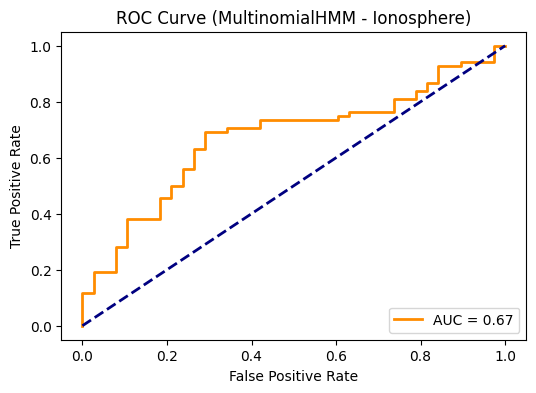

In [ ]:
# Block 7 (Fixed) - ROC Curve and AUC
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def scores_to_prob(log_probs, classes, positive_class=1):
    exp = np.exp(log_probs - np.max(log_probs))
    probs = exp / exp.sum()
    idx = classes.index(positive_class)
    return probs[idx]

y_prob = []
for seq in X_test:
    seq = seq.reshape(1, -1)  # <-- FIX: row vector of feature counts
    log_probs = [models[c].score(seq) for c in classes]
    y_prob.append(scores_to_prob(log_probs, classes, positive_class=1))
y_prob = np.array(y_prob)

# ROC & AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (MultinomialHMM - Ionosphere)")
plt.legend(loc="lower right")
plt.show()


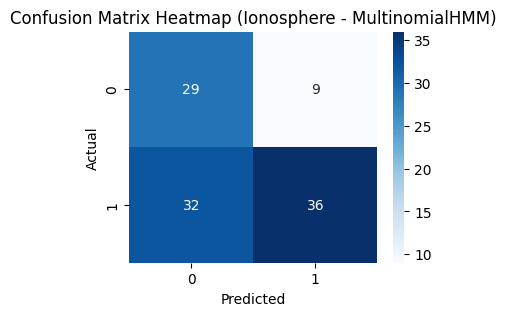

In [ ]:
# Block 8 - Confusion Matrix Heatmap
import seaborn as sns

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Heatmap (Ionosphere - MultinomialHMM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**<<<<------------GaussianHMM on Ionosphere Dataset----------->>>>**

In [ ]:
# Load dataset from UCI repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
columns = [f"feature_{i}" for i in range(34)] + ["target"]
df = pd.read_csv(url, header=None, names=columns)

# Convert target to numeric (g = 1, b = 0)
df['target'] = df['target'].map({'g': 1, 'b': 0})

# Display first few rows
df.head()


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,target
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,1


In [ ]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.8, random_state=42, stratify=y)


In [ ]:
# Initialize and train model
classifier = GaussianHMM(n_components=4, covariance_type="full", n_iter=200, random_state=42)
classifier.fit(X_train)

# Predict
y_pred = classifier.predict(X_test)


In [ ]:
# Print confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print("-----------------------------------------")
print("Performance Evaluation...")
print(classification_report(y_test, y_pred))
print("-----------------------------------------")


[[ 29   5  67]
 [  0   0 180]
 [  0   0   0]]
-----------------------------------------
Performance Evaluation...
              precision    recall  f1-score   support

           0       1.00      0.29      0.45       101
           1       0.00      0.00      0.00       180
           2       0.00      0.00      0.00         0

    accuracy                           0.10       281
   macro avg       0.33      0.10      0.15       281
weighted avg       0.36      0.10      0.16       281

-----------------------------------------


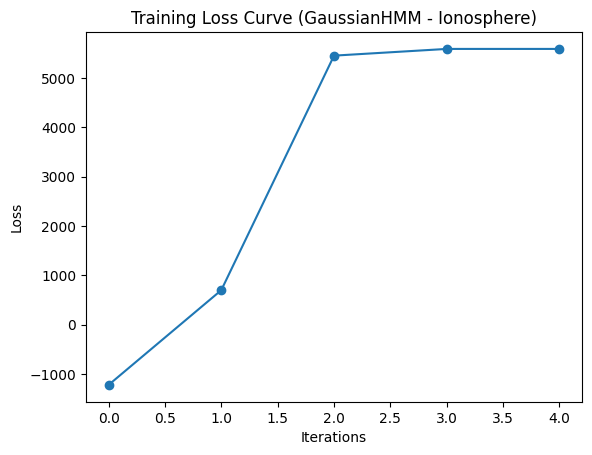

In [ ]:
loss_values = classifier.monitor_.history
plt.plot(loss_values, marker='o')
plt.title("Training Loss Curve (GaussianHMM - Ionosphere)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()


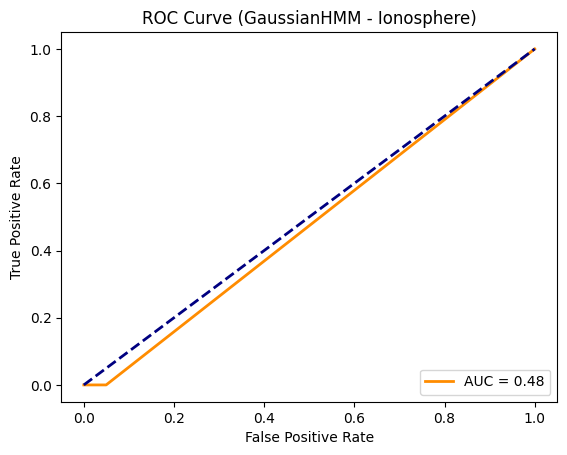

In [ ]:
y_score = classifier.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color="darkorange", lw=2, label="AUC = {:.2f}".format(roc_auc))
plt.plot([0,1],[0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (GaussianHMM - Ionosphere)")
plt.legend(loc="lower right")
plt.show()


**<<<<-------------For MNIST Dataset------------>>>>**

In [ ]:
# import and load the data
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# Reshape for CNN input
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Built CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])


In [ ]:
# comppile and train
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=5,
                    validation_data=(x_test, y_test))


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 57s 29ms/step - accuracy: 0.9019 - loss: 0.3186 - val_accuracy: 0.9842 - val_loss: 0.0529
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 57s 30ms/step - accuracy: 0.9849 - loss: 0.0497 - val_accuracy: 0.9888 - val_loss: 0.0347
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 54s 29ms/step - accuracy: 0.9911 - loss: 0.0294 - val_accuracy: 0.9863 - val_loss: 0.0424
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 66s 35ms/step - accuracy: 0.9929 - loss: 0.0247 - val_accuracy: 0.9916 - val_loss: 0.0288
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 54s 29ms/step - accuracy: 0.9953 - loss: 0.0156 - val_accuracy: 0.9854 - val_loss: 0.0480


In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("MNIST Test Accuracy:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9792 - loss: 0.0674
MNIST Test Accuracy: 0.9854000210762024


**<<<<------------------CIFAR-10 Dataset---------------->>>>**

In [ ]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 176s 1us/step


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_test, y_test))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 78s 49ms/step - accuracy: 0.3571 - loss: 1.7321 - val_accuracy: 0.5302 - val_loss: 1.2799
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.5719 - loss: 1.2165 - val_accuracy: 0.6148 - val_loss: 1.0934
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 46ms/step - accuracy: 0.6388 - loss: 1.0289 - val_accuracy: 0.6483 - val_loss: 1.0129
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.6726 - loss: 0.9295 - val_accuracy: 0.6720 - val_loss: 0.9439
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - accuracy: 0.7015 - loss: 0.8488 - val_accuracy: 0.6860 - val_loss: 0.9177
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 79s 46ms/step - accuracy: 0.7245 - loss: 0.7814 - val_accuracy: 0.6793 - val_loss: 0.9359
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.7420 - loss: 0.7359 - val_accuracy: 0.7059 - val_loss: 0.8650
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - accuracy: 0.7583 -

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("CIFAR-10 Test Accuracy:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7011 - loss: 0.8930
CIFAR-10 Test Accuracy: 0.6956999897956848


**<<<<-------Comparison of 4 different models with that of CIFAR-10------>>>>**

In [ ]:
# Load the CIFAR datas
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
## CNN model(baseline)
cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])
cnn.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
cnn_history = cnn.fit(x_train, y_train, epochs=10,
                      validation_data=(x_val, y_val), batch_size=64)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - accuracy: 0.3354 - loss: 1.8253 - val_accuracy: 0.5055 - val_loss: 1.3640
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.5477 - loss: 1.2749 - val_accuracy: 0.5669 - val_loss: 1.2482
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 81ms/step - accuracy: 0.6081 - loss: 1.1263 - val_accuracy: 0.6248 - val_loss: 1.0793
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.6423 - loss: 1.0215 - val_accuracy: 0.6222 - val_loss: 1.0850
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.6644 - loss: 0.9700 - val_accuracy: 0.6481 - val_loss: 1.0075
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 84ms/step - accuracy: 0.6828 - loss: 0.9117 - val_accuracy: 0.6548 - val_loss: 0.9995
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.7056 - loss: 0.8556 - val_accuracy: 0.6639 - val_loss: 0.9861
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 80ms/step - accuracy: 0.7163 - loss: 0.8184 - 

In [ ]:
from tensorflow.keras.applications import VGG16
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
for layer in base_vgg.layers: layer.trainable = False

vgg = models.Sequential([
    base_vgg,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])
vgg.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
vgg_history = vgg.fit(x_train, y_train, epochs=5,
                      validation_data=(x_val, y_val), batch_size=64)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 624s 997ms/step - accuracy: 0.4446 - loss: 1.5755 - val_accuracy: 0.5582 - val_loss: 1.2617
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 620s 993ms/step - accuracy: 0.5814 - loss: 1.2060 - val_accuracy: 0.5868 - val_loss: 1.1905
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 622s 993ms/step - accuracy: 0.6048 - loss: 1.1321 - val_accuracy: 0.5938 - val_loss: 1.1612
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 623s 994ms/step - accuracy: 0.6160 - loss: 1.0958 - val_accuracy: 0.6046 - val_loss: 1.1258
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 602s 962ms/step - accuracy: 0.6361 - loss: 1.0473 - val_accuracy: 0.6045 - val_loss: 1.1320


In [ ]:
alexnet = models.Sequential([
    layers.Conv2D(96, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])
alexnet.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
alexnet_history = alexnet.fit(x_train, y_train, epochs=8,
                              validation_data=(x_val, y_val), batch_size=64)


Epoch 1/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 317s 505ms/step - accuracy: 0.3825 - loss: 1.6960 - val_accuracy: 0.5823 - val_loss: 1.1719
Epoch 2/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 316s 506ms/step - accuracy: 0.6189 - loss: 1.0884 - val_accuracy: 0.6653 - val_loss: 0.9695
Epoch 3/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 314s 502ms/step - accuracy: 0.6819 - loss: 0.9040 - val_accuracy: 0.6968 - val_loss: 0.8860
Epoch 4/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 316s 506ms/step - accuracy: 0.7329 - loss: 0.7513 - val_accuracy: 0.6953 - val_loss: 0.8789
Epoch 5/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 314s 503ms/step - accuracy: 0.7885 - loss: 0.6081 - val_accuracy: 0.7049 - val_loss: 0.8995
Epoch 6/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 318s 508ms/step - accuracy: 0.8398 - loss: 0.4674 - val_accuracy: 0.7216 - val_loss: 0.8738
Epoch 7/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 316s 506ms/step - accuracy: 0.8772 - loss: 0.3498 - val_accuracy: 0.7055 - val_loss: 0.9918
Epoch 8/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 324s 510ms/step - accuracy: 0.9170 - loss: 0

In [ ]:
base_incep = InceptionV3(weights='imagenet', include_top=False, input_shape=(75,75,3))
for layer in base_incep.layers: layer.trainable = False

x_train_resized = tf.image.resize(x_train, (75,75))
x_val_resized   = tf.image.resize(x_val, (75,75))
x_test_resized  = tf.image.resize(x_test, (75,75))

googlenet = models.Sequential([
    base_incep,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])
googlenet.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
googlenet_history = googlenet.fit(x_train_resized, y_train, epochs=5,
                                  validation_data=(x_val_resized, y_val),
                                  batch_size=64)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 527s 826ms/step - accuracy: 0.5120 - loss: 1.4151 - val_accuracy: 0.6113 - val_loss: 1.1196
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 459s 734ms/step - accuracy: 0.6633 - loss: 0.9730 - val_accuracy: 0.6234 - val_loss: 1.0901
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 551s 813ms/step - accuracy: 0.7146 - loss: 0.8239 - val_accuracy: 0.6231 - val_loss: 1.0890
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 455s 729ms/step - accuracy: 0.7643 - loss: 0.6877 - val_accuracy: 0.6212 - val_loss: 1.1325
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 557s 816ms/step - accuracy: 0.8208 - loss: 0.5379 - val_accuracy: 0.6193 - val_loss: 1.1968


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


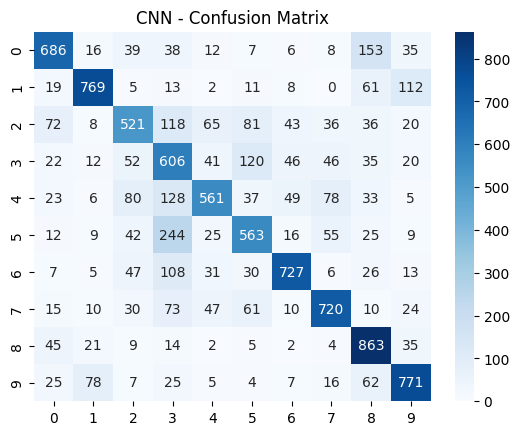

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


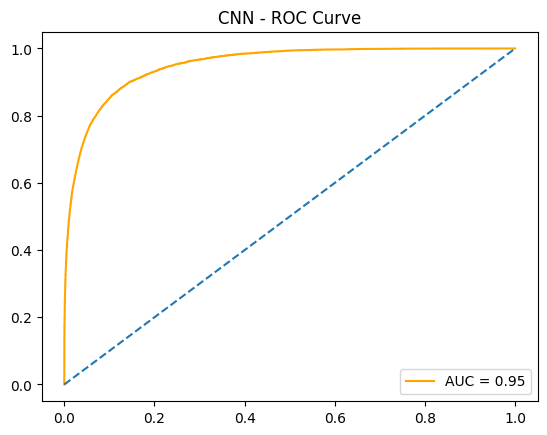

313/313 ━━━━━━━━━━━━━━━━━━━━ 128s 408ms/step


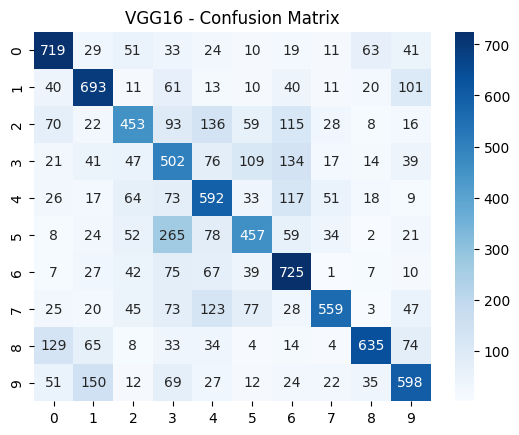

313/313 ━━━━━━━━━━━━━━━━━━━━ 122s 390ms/step


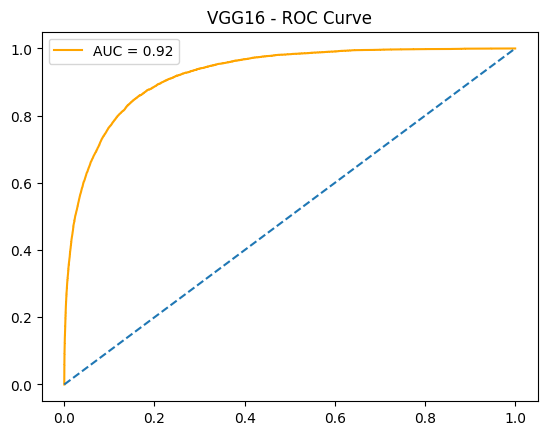

313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step


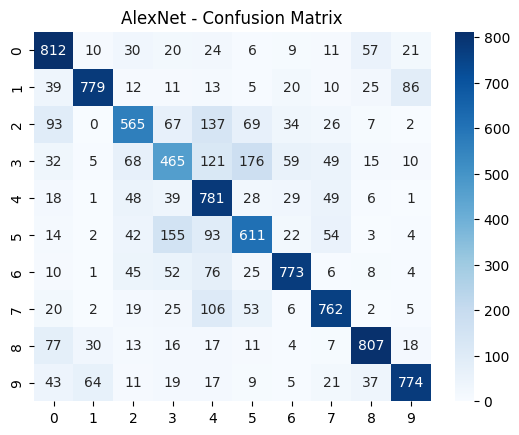

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step


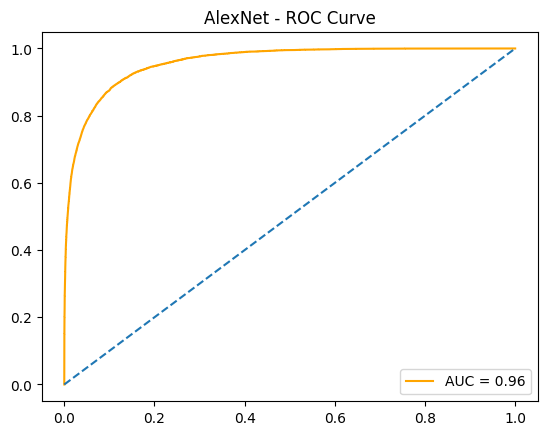

313/313 ━━━━━━━━━━━━━━━━━━━━ 103s 320ms/step


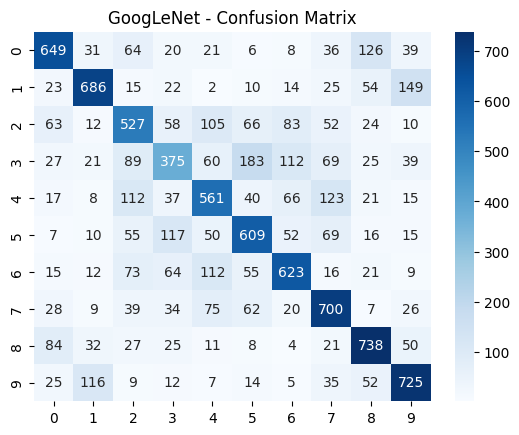

313/313 ━━━━━━━━━━━━━━━━━━━━ 98s 315ms/step


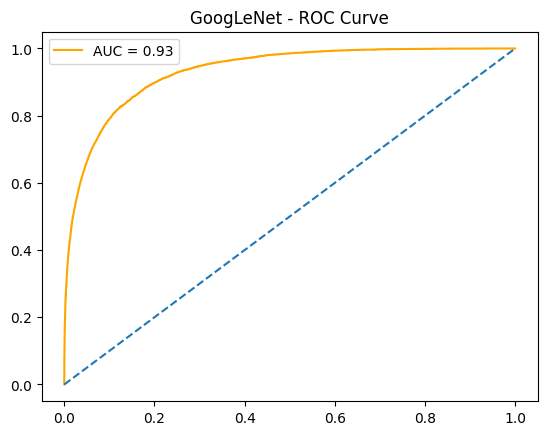

In [ ]:
def evaluate_model(model, x_t, y_t, title):
    y_pred = np.argmax(model.predict(x_t), axis=1)
    y_true = y_t.flatten()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{title} - Confusion Matrix")
    plt.show()

    # ROC Curve (macro)
    y_prob = model.predict(x_t)
    y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=10)
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1],[0,1], linestyle='--')
    plt.title(f"{title} - ROC Curve")
    plt.legend()
    plt.show()

    acc = model.evaluate(x_t, y_t, verbose=0)[1]
    return acc

cnn_acc = evaluate_model(cnn, x_test, y_test, "CNN")
vgg_acc = evaluate_model(vgg, x_test, y_test, "VGG16")
alex_acc = evaluate_model(alexnet, x_test, y_test, "AlexNet")
goog_acc = evaluate_model(googlenet, x_test_resized, y_test, "GoogLeNet")


In [ ]:
import pandas as pd
results = pd.DataFrame({
    "Model": ["CNN","VGG16","AlexNet","GoogLeNet"],
    "Accuracy": [cnn_acc, vgg_acc, alex_acc, goog_acc]
})
print(results)


       Model  Accuracy
0        CNN    0.6787
1      VGG16    0.5933
2    AlexNet    0.7129
3  GoogLeNet    0.6193


**<<<<--------Comparison of 4 different models with that of MNIST------>>>>**

In [ ]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# Normalize and reshape
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# One-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("Train shape:", x_train.shape, "Test shape:", x_test.shape)


Train shape: (60000, 28, 28, 1) Test shape: (10000, 28, 28, 1)


In [ ]:
# CNN model for MNIST
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

# Train
history_cnn = cnn_model.fit(x_train, y_train, epochs=8, batch_size=64, validation_split=0.1, verbose=1)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_103 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 49s 56ms/step - accuracy: 0.8812 - loss: 0.3937 - val_accuracy: 0.9843 - val_loss: 0.0527
Epoch 2/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - accuracy: 0.9829 - loss: 0.0553 - val_accuracy: 0.9888 - val_loss: 0.0392
Epoch 3/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - accuracy: 0.9880 - loss: 0.0350 - val_accuracy: 0.9895 - val_loss: 0.0386
Epoch 4/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 47s 56ms/step - accuracy: 0.9924 - loss: 0.0244 - val_accuracy: 0.9898 - val_loss: 0.0377
Epoch 5/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 45s 53ms/step - accuracy: 0.9946 - loss: 0.0167 - val_accuracy: 0.9913 - val_loss: 0.0328
Epoch 6/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 84s 56ms/step - accuracy: 0.9950 - loss: 0.0142 - val_accuracy: 0.9900 - val_loss: 0.0407
Epoch 7/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - accuracy: 0.9967 - loss: 0.0105 - val_accuracy: 0.9907 - val_loss: 0.0413
Epoch 8/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 53ms/step - accuracy: 0.9970 - loss: 0.0095 - val_accu

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9887 - loss: 0.0390
CNN Test Accuracy: 0.9911999702453613


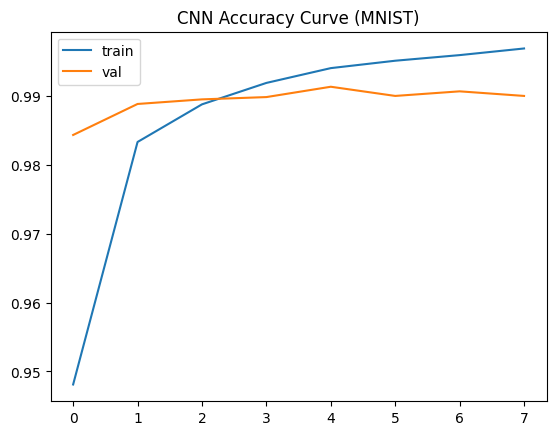

In [ ]:
# Evaluation
test_loss, test_acc = cnn_model.evaluate(x_test, y_test)
print("CNN Test Accuracy:", test_acc)

# Plot training
plt.plot(history_cnn.history['accuracy'], label='train')
plt.plot(history_cnn.history['val_accuracy'], label='val')
plt.title("CNN Accuracy Curve (MNIST)")
plt.legend()
plt.show()


In [ ]:
# Convert 1 channel → 3 channels for VGG16
x_train_vgg = np.repeat(x_train, 3, axis=-1)
x_test_vgg = np.repeat(x_test, 3, axis=-1)

# Resize to 32x32 (VGG input)
x_train_vgg = tf.image.resize(x_train_vgg, (32,32))
x_test_vgg = tf.image.resize(x_test_vgg, (32,32))


In [ ]:
# VGG16 model for MNIST
vgg_base = VGG16(weights=None, include_top=False, input_shape=(32,32,3))
vgg_model = models.Sequential([
    vgg_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])

vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()

# Train
history_vgg = vgg_model.fit(x_train_vgg, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)


In [ ]:
test_loss, test_acc = vgg_model.evaluate(x_test_vgg, y_test)
print("VGG16 Test Accuracy:", test_acc)

plt.plot(history_vgg.history['accuracy'], label='train')
plt.plot(history_vgg.history['val_accuracy'], label='val')
plt.title("VGG16 Accuracy Curve (MNIST)")
plt.legend()
plt.show()


In [ ]:
# Resize MNIST for InceptionV3 (75x75, 3 channels)
x_train_inc = tf.image.resize(x_train_vgg, (75,75))
x_test_inc = tf.image.resize(x_test_vgg, (75,75))

inc_base = InceptionV3(weights=None, include_top=False, input_shape=(75,75,3))
inc_model = models.Sequential([
    inc_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])

inc_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
inc_model.summary()

history_inc = inc_model.fit(x_train_inc, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)


In [ ]:
test_loss, test_acc = inc_model.evaluate(x_test_inc, y_test)
print("InceptionV3 Test Accuracy:", test_acc)

plt.plot(history_inc.history['accuracy'], label='train')
plt.plot(history_inc.history['val_accuracy'], label='val')
plt.title("InceptionV3 Accuracy Curve (MNIST)")
plt.legend()
plt.show()

# Compare model performance
models_acc = {
    'CNN': cnn_model.evaluate(x_test, y_test, verbose=0)[1],
    'VGG16': vgg_model.evaluate(x_test_vgg, y_test, verbose=0)[1],
    'InceptionV3': inc_model.evaluate(x_test_inc, y_test, verbose=0)[1]
}

plt.bar(models_acc.keys(), models_acc.values(), color=['skyblue','orange','green'])
plt.title("Model Accuracy Comparison (MNIST)")
plt.ylabel("Accuracy")
plt.show()

for name, acc in models_acc.items():
    print(f"{name}: {acc*100:.2f}%")
